In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from PIL import Image


/Users/temiloluw.adeoti/codes-and-scripts/exploration/learn-by-doing/lbd-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset
- **HuggingFaceDataset**: Ryan-sjtu/celebahq-caption


### Things to Note
1. checkpointing datasets:
2. reshuffling after each epoch: https://huggingface.co/docs/datasets/stream
3. in distributed setting, map on rank 0 alone: https://huggingface.co/docs/datasets/process#distributed-usage

In [8]:
REPO_ID = "Ryan-sjtu/celebahq-caption"
CACHE_DIR = f"data/{REPO_ID.lower().replace('/', '-')}"
SEED = 24
BUFFER_SIZE = 100
BATCH_SIZE = 12
IMAGE_SIZE = 256    
NUM_WORKERS = 0

os.makedirs(CACHE_DIR, exist_ok=True)

ds = load_dataset(REPO_ID, 
                  split='train', 
                  streaming=True, 
                  trust_remote_code=True,
                  cache_dir=CACHE_DIR,)


In [9]:
class CustomResizeAndCrop:
    def __init__(self, target_size=IMAGE_SIZE):
        self.target_size = target_size

    def __call__(self, image):
        width, height = image.size
        if width > height:
            scale = self.target_size / width
        else:
            scale = self.target_size / height

        new_width = int(width * scale)
        new_height = int(height * scale)

        resized_image = transforms.Resize((new_height, new_width))(image)
        final_image = transforms.CenterCrop(self.target_size)(resized_image)

        return final_image

transform_list = transforms.Compose([
    CustomResizeAndCrop(target_size=IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), #  slight color jitter
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize using imagenet values
])

In [13]:
def preprocess(samples):
    samples['text'] = [i.lower() for i in samples['text']]
    return samples

def collate_fn(batch):
    images = []
    texts = []

    for item in batch:
        image = item['image']
        label = item['text']  

        if transform_list:
            image = transform_list(image)

        images.append(image)
        texts.append(label)

    return images, texts


shuffled_ds = ds.shuffle(seed=SEED, buffer_size=BUFFER_SIZE)\
                .map(preprocess, 
                    batch_size=BATCH_SIZE,
                    batched=True)


dataloader = DataLoader(
    dataset=shuffled_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,  
)

for images, texts in dataloader:
    print(images[0].shape, texts[0])
    break
    pass

torch.Size([3, 256, 256]) a photography of a man with a black suit and tie


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.92941177].
Clipping input da

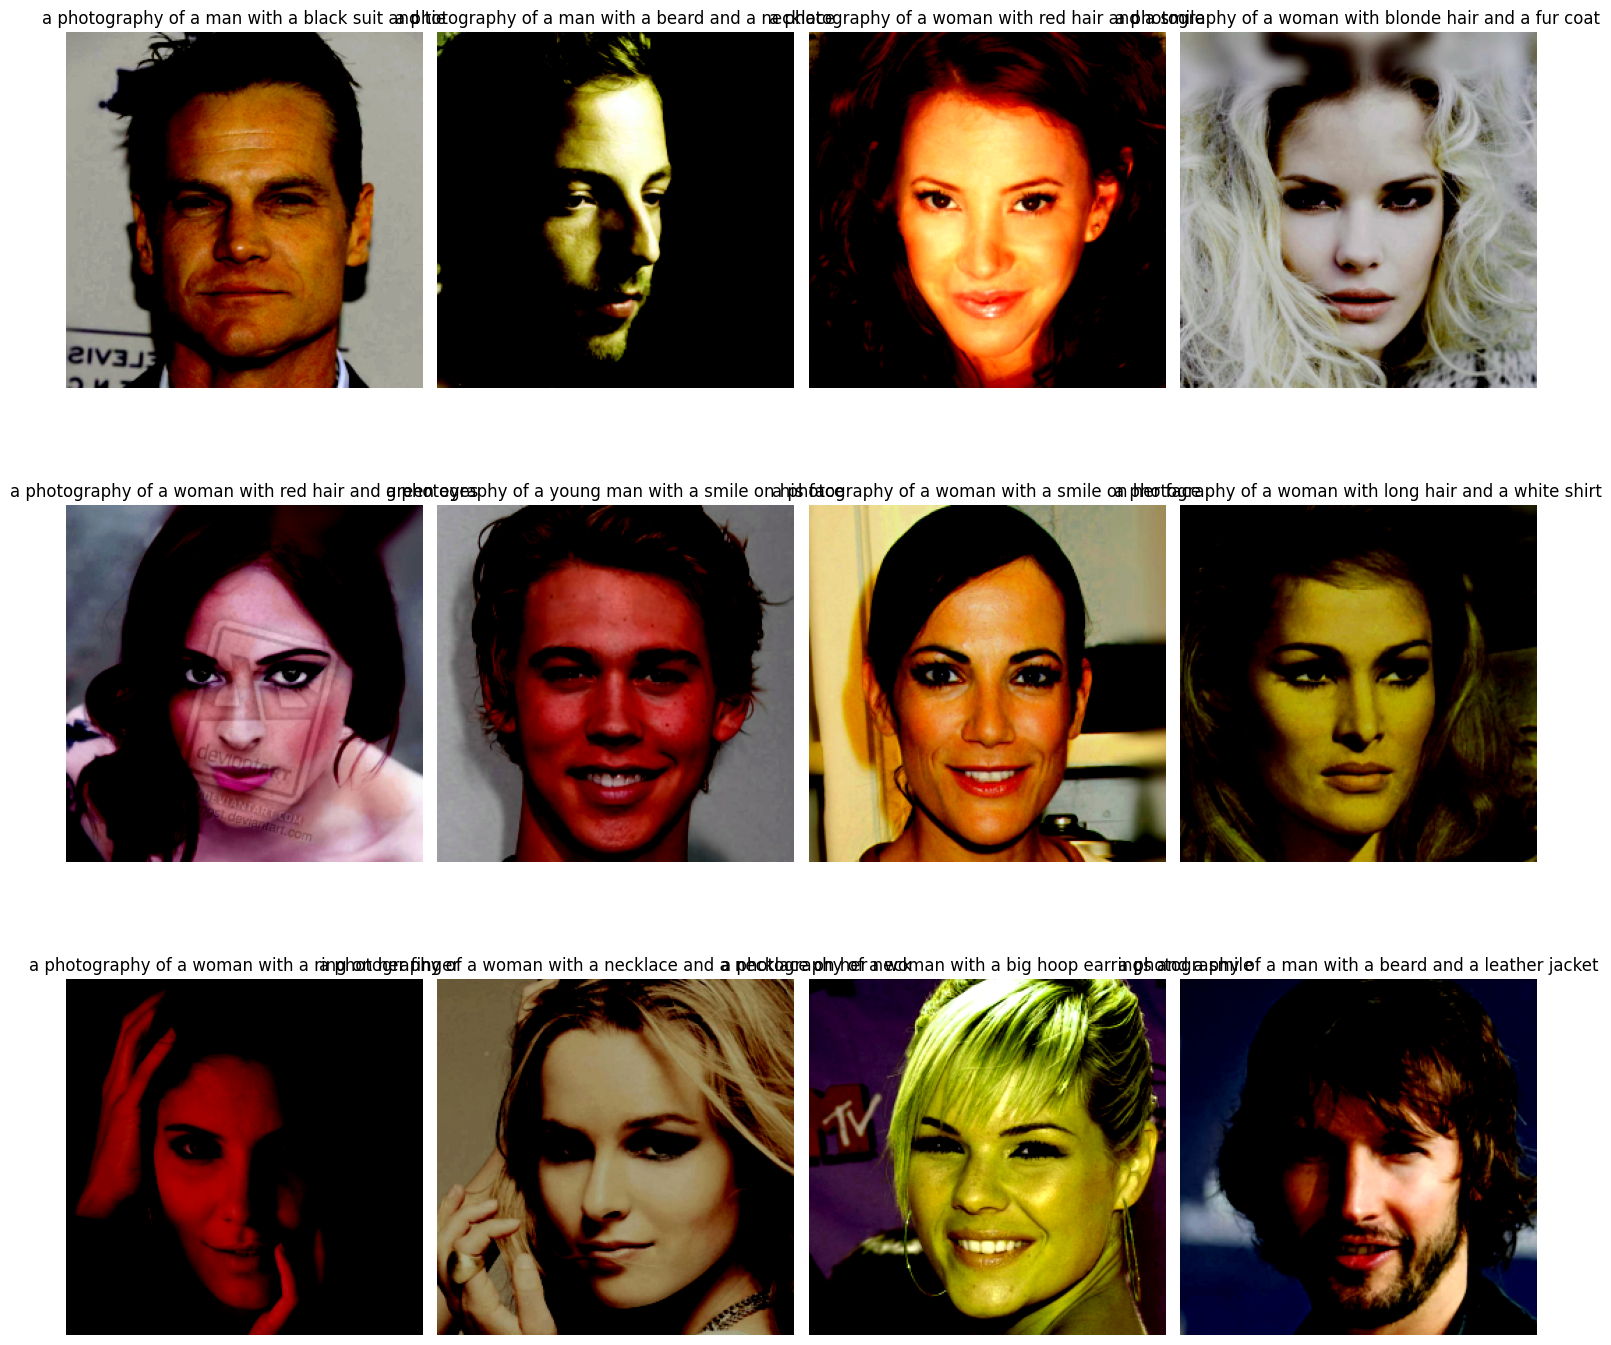

In [11]:
import matplotlib.pyplot as plt

def visualize_images(images, titles=None, cols=4):
    """Visualize a batch of images using matplotlib.

    Args:
        images (list of tensors): A list of image tensors to visualize.
        titles (list of str, optional): Titles for each image.
        cols (int): Number of columns in the grid layout.
    """
    # Convert images to numpy arrays for visualization
    images = [image.permute(1, 2, 0).numpy() for image in images]  # Convert (C, H, W) to (H, W, C)
    fig, axes = plt.subplots(nrows=(len(images) + cols - 1) // cols, ncols=cols, figsize=(15, 15))
    
    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img)
        ax.axis('off')  # Hide axes ticks

    if titles is not None:
        for ax, title in zip(axes.flatten(), titles):
            ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

visualize_images(images, titles=texts, cols=4)

# Variational Autoencoder

In [ ]:

class ResBlock(nn.Module):
    def __init__(self, channels, num_groups):
        super(ResBlock, self).__init__()
        self.gn1 = nn.GroupNorm(num_groups, channels)
        self.gn2 = nn.GroupNorm(num_groups, channels)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.gn1(x)
        out = F.silu(out)
        out = self.conv1(out)
        out = self.gn2(out)
        out = F.silu(out)
        out = self.conv2(out)
        out += residual
        return out

class CVAE(nn.Module):
    """Convolutional Variational Autoencoder with ResNet connections."""
    def __init__(self, base_channels, num_groups=8, dropout_prob=0.5):
        super(CVAE, self).__init__()
        self.latent_dim = 128
        self.dropout_prob = dropout_prob

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size=3, padding=1),
            self._conv_block(base_channels, base_channels, stride=2, num_groups=num_groups),  # (256, 256) -> (128, 128)
            ResBlock(base_channels, num_groups),
            self._conv_block(base_channels, base_channels * 2, stride=2, num_groups=num_groups),  # (128, 128) -> (64, 64)
            ResBlock(base_channels * 2, num_groups),
            self._conv_block(base_channels * 2, base_channels * 4, stride=2, num_groups=num_groups),  # (64, 64) -> (32, 32)
            ResBlock(base_channels * 4, num_groups),
            self._conv_block(base_channels * 4, base_channels * 8, stride=2, num_groups=num_groups),  # (32, 32) -> (16, 16)
            ResBlock(base_channels * 8, num_groups),
            nn.Flatten(),
        )

        self.flattened_dims = base_channels * 8 * 16 * 16
        self.fc_mean = nn.Linear(self.flattened_dims, self.latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dims, self.latent_dim)

        self.decoder_input = nn.Linear(self.latent_dim, self.flattened_dims)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (base_channels * 8, 16, 16)),
            ResBlock(base_channels * 8, num_groups),
            self._conv_transpose_block(base_channels * 8, base_channels * 4, num_groups=num_groups),  # (16, 16) -> (32, 32)
            ResBlock(base_channels * 4, num_groups),
            self._conv_transpose_block(base_channels * 4, base_channels * 2, num_groups=num_groups),  # (32, 32) -> (64, 64)
            ResBlock(base_channels * 2, num_groups),
            self._conv_transpose_block(base_channels * 2, base_channels, num_groups=num_groups),  # (64, 64) -> (128, 128)
            ResBlock(base_channels, num_groups),
            self._conv_transpose_block(base_channels, base_channels // 2, num_groups=num_groups),  # (128, 128) -> (256, 256)
            nn.GroupNorm(num_groups, base_channels // 2),
            nn.SiLU(),
            nn.Conv2d(base_channels // 2, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def _conv_block(self, in_channels, out_channels, stride=1, num_groups=8):
        return nn.Sequential(
            nn.GroupNorm(num_groups, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.Dropout(self.dropout_prob) 
            
        )

    def _conv_transpose_block(self, in_channels, out_channels, num_groups=8):
        return nn.Sequential(
            nn.GroupNorm(num_groups, in_channels),
            nn.SiLU(),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.Dropout(self.dropout_prob)
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mean(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    @staticmethod
    def recommend_num_groups(base_channels):
        """Recommend the number of groups for GroupNorm based on base channels."""
        if base_channels < 16:
            return 4
        elif base_channels < 64:
            return 8
        elif base_channels < 256:
            return 16
        else:
            return 32


base_channels = 32  
num_groups = CVAE.recommend_num_groups(base_channels)
dropout_prob = 0.1 
img_size = 256

model = CVAE(base_channels, num_groups=num_groups, dropout_prob=dropout_prob)
input_image = torch.randn(1, 3, img_size, img_size)
output_image, mu, logvar = model(input_image)
print(output_image.shape) 

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10

class CVAELightning(pl.LightningModule):
    def __init__(self, img_size=32, latent_dim=128, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = CVAE(img_size)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        recon_x, mu, logvar = self(x)
        loss = self.loss_function(recon_x, x, mu, logvar)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        recon_x, mu, logvar = self(x)
        loss = self.loss_function(recon_x, x, mu, logvar)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        recon_x, mu, logvar = self(x)
        loss = self.loss_function(recon_x, x, mu, logvar)
        self.log('test_loss', loss)

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def prepare_data(self):
        # Download the CIFAR10 dataset
        CIFAR10(root='./data', train=True, download=True)
        CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        # Transform
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        # Load and split datasets
        if stage == 'fit' or stage is None:
            cifar_full = CIFAR10(root='./data', train=True, transform=transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        if stage == 'test' or stage is None:
            self.cifar_test = CIFAR10(root='./data', train=False, transform=transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=64, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=64, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=64, num_workers=4)

# Example usage:
model = CVAELightning(img_size=32, latent_dim=128)
trainer = pl.Trainer(max_epochs=10, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(model)